# Private training algorithm (DP-SGD, DP-Adam, ...) with Opacus

Training the neural network with DP-SGD requires
* clipping sample gradients,
* and adding perturbations.
which is not only degrades the performance but also requires additional computational costs.

In this practice, we would use Opacus, the packages for private training in PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from opacus import PrivacyEngine
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import time

In [2]:
# construct dataloader
def get_fmnist_dataloader(path='./data'):
    transform = transforms.ToTensor()
    
    train_set = datasets.FashionMNIST(root=path, train=True, transform=transform, download=True)
    test_set = datasets.FashionMNIST(root=path, train=False, transform=transform, download=True)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)
    
    return train_loader, test_loader

# models - logistic regression, multi-layer perceptron
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
        
    def forward(self, inputs):
        return self.linear(self.flatten(inputs))
    
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)
        
    def forward(self, inputs):
        return self.linear2(F.tanh(self.linear1(self.flatten(inputs))))
    
    
# function for one loop of training
def loop(model, loader, optimizer, epoch_idx=-1, mode='train', device='cpu'):
    loss_list = []
    acc_list = []
    batch_num_samples = []
    for samples, targets in loader:
        samples = samples.to(device)
        targets = targets.to(device)
        
        preds = model(samples)
        loss = F.cross_entropy(preds, targets)
        acc = (preds.topk(1, dim=1).indices == targets.unsqueeze(1)).all(1).float().mean()
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss_list.append(loss.item())
        acc_list.append(acc.item())
        batch_num_samples.append(samples.size(0))
    
    # print([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])
    # print(torch.sum(torch.tensor([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])))
    loss = torch.sum(torch.tensor([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])) / torch.sum(torch.tensor(batch_num_samples))
    acc = torch.sum(torch.tensor([acc_list[i] * batch_num_samples[i] for i in range(len(acc_list))])) / torch.sum(torch.tensor(batch_num_samples))
    print(f"Epoch {epoch_idx} - {mode:^6} loss {loss:.3f}, acc {acc:.3f}")
    return loss, acc

In [3]:
# conventional non-private training
def train(model_type='linear'):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)

In [4]:
start_time = time.time()
non_private_linear_history = train(model_type='linear')
print(f"Running for {time.time()-start_time} seconds.")

Epoch 0 - train  loss 0.911, acc 0.722
Epoch 0 -  test  loss 0.705, acc 0.773
Epoch 1 - train  loss 0.638, acc 0.797
Epoch 1 -  test  loss 0.623, acc 0.795
Epoch 2 - train  loss 0.580, acc 0.812
Epoch 2 -  test  loss 0.584, acc 0.805
Epoch 3 - train  loss 0.548, acc 0.822
Epoch 3 -  test  loss 0.562, acc 0.813
Epoch 4 - train  loss 0.527, acc 0.826
Epoch 4 -  test  loss 0.545, acc 0.817
Epoch 5 - train  loss 0.512, acc 0.831
Epoch 5 -  test  loss 0.532, acc 0.820
Epoch 6 - train  loss 0.500, acc 0.834
Epoch 6 -  test  loss 0.523, acc 0.824
Epoch 7 - train  loss 0.491, acc 0.836
Epoch 7 -  test  loss 0.515, acc 0.826
Epoch 8 - train  loss 0.484, acc 0.839
Epoch 8 -  test  loss 0.511, acc 0.825
Epoch 9 - train  loss 0.477, acc 0.840
Epoch 9 -  test  loss 0.503, acc 0.828
Epoch 10 - train  loss 0.471, acc 0.842
Epoch 10 -  test  loss 0.500, acc 0.829
Epoch 11 - train  loss 0.466, acc 0.843
Epoch 11 -  test  loss 0.498, acc 0.828
Epoch 12 - train  loss 0.462, acc 0.845
Epoch 12 -  test  lo

<Figure size 640x480 with 0 Axes>

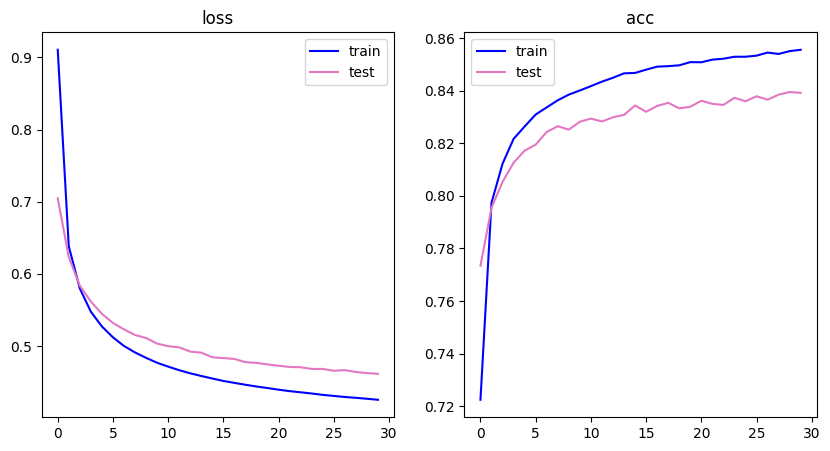

In [5]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    history = non_private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, history[0], color=color_list[0])
    ax.plot(epochs, history[1], color=color_list[9])
    ax.axis("tight")
    ax.legend(['train', 'test'])
    
plt.show()

Recall the noise multiplier of DP-SGD is derived from the given privacy budget.

In [6]:
# privitize the training procedure - Opacus automatically supports ghost clipping
def train_private(model_type='linear', noise_multiplier=1.1, clipping_threshold=1.0):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=clipping_threshold,
    )
    
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)


# explicit usage of privacy budget (epsilon, delta)
def train_private_with_privacy_budget(model_type='linear', epsilon=1.0, delta=1e-5, clipping_threshold=1.0):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        target_epsilon=epsilon,
        target_delta=delta,
        epochs=30,
        max_grad_norm=clipping_threshold,
    )
    
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)

In [7]:
start_time = time.time()
private_linear_history = train_private_with_privacy_budget(model_type='linear', epsilon=1.0)
print(f"Running for {time.time()-start_time} seconds.")

/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be remo

Epoch 0 - train  loss 1.603, acc 0.551
Epoch 0 -  test  loss 1.241, acc 0.585
Epoch 1 - train  loss 1.090, acc 0.621
Epoch 1 -  test  loss 0.997, acc 0.643
Epoch 2 - train  loss 0.928, acc 0.663
Epoch 2 -  test  loss 0.890, acc 0.669
Epoch 3 - train  loss 0.841, acc 0.689
Epoch 3 -  test  loss 0.837, acc 0.684
Epoch 4 - train  loss 0.802, acc 0.706
Epoch 4 -  test  loss 0.802, acc 0.699
Epoch 5 - train  loss 0.763, acc 0.722
Epoch 5 -  test  loss 0.775, acc 0.717
Epoch 6 - train  loss 0.743, acc 0.734
Epoch 6 -  test  loss 0.757, acc 0.729
Epoch 7 - train  loss 0.728, acc 0.747
Epoch 7 -  test  loss 0.737, acc 0.740
Epoch 8 - train  loss 0.713, acc 0.755
Epoch 8 -  test  loss 0.729, acc 0.747
Epoch 9 - train  loss 0.705, acc 0.759
Epoch 9 -  test  loss 0.717, acc 0.754
Epoch 10 - train  loss 0.689, acc 0.768
Epoch 10 -  test  loss 0.711, acc 0.757
Epoch 11 - train  loss 0.681, acc 0.772
Epoch 11 -  test  loss 0.701, acc 0.762
Epoch 12 - train  loss 0.683, acc 0.774
Epoch 12 -  test  lo

<Figure size 640x480 with 0 Axes>

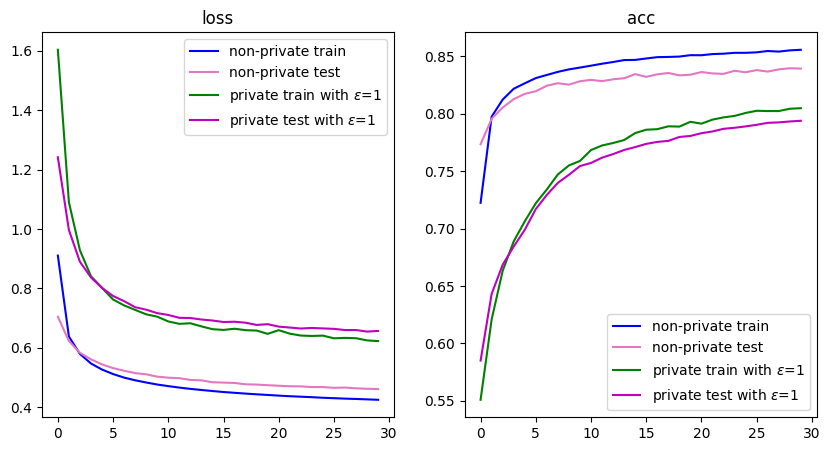

In [8]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = non_private_linear_history[i]
    p_history = private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[0])
    ax.plot(epochs, np_history[1], color=color_list[9])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['non-private train', 'non-private test', 'private train with $\epsilon$=1', 'private test with $\epsilon$=1'])
    
plt.show()

In [9]:
start_time = time.time()
private_linear_history_8 = train_private_with_privacy_budget(model_type='linear', epsilon=8.0)
print(f"Running for {time.time()-start_time} seconds.")

Epoch 0 - train  loss 1.628, acc 0.554
Epoch 0 -  test  loss 1.232, acc 0.630
Epoch 1 - train  loss 1.095, acc 0.634
Epoch 1 -  test  loss 0.993, acc 0.647
Epoch 2 - train  loss 0.919, acc 0.668
Epoch 2 -  test  loss 0.894, acc 0.665
Epoch 3 - train  loss 0.841, acc 0.690
Epoch 3 -  test  loss 0.834, acc 0.687
Epoch 4 - train  loss 0.803, acc 0.706
Epoch 4 -  test  loss 0.800, acc 0.706
Epoch 5 - train  loss 0.767, acc 0.725
Epoch 5 -  test  loss 0.774, acc 0.719
Epoch 6 - train  loss 0.743, acc 0.737
Epoch 6 -  test  loss 0.757, acc 0.729
Epoch 7 - train  loss 0.730, acc 0.747
Epoch 7 -  test  loss 0.743, acc 0.738
Epoch 8 - train  loss 0.713, acc 0.757
Epoch 8 -  test  loss 0.729, acc 0.747
Epoch 9 - train  loss 0.701, acc 0.762
Epoch 9 -  test  loss 0.719, acc 0.753
Epoch 10 - train  loss 0.691, acc 0.767
Epoch 10 -  test  loss 0.715, acc 0.756
Epoch 11 - train  loss 0.686, acc 0.775
Epoch 11 -  test  loss 0.707, acc 0.762
Epoch 12 - train  loss 0.680, acc 0.775
Epoch 12 -  test  lo

<Figure size 640x480 with 0 Axes>

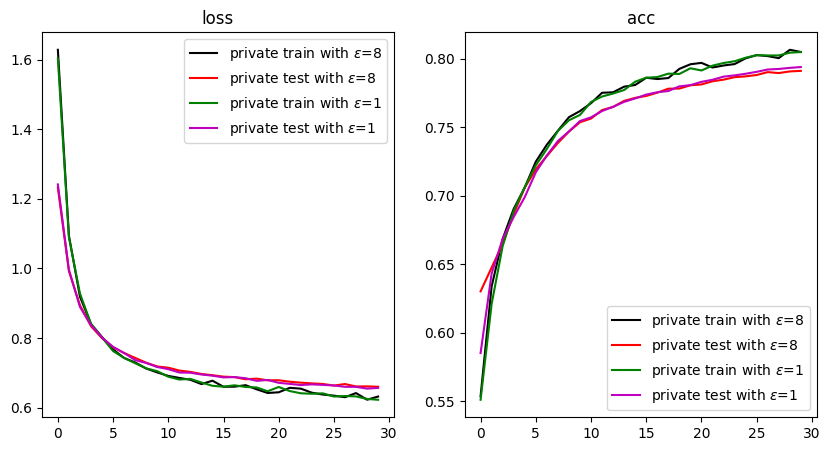

In [10]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = private_linear_history_8[i]
    p_history = private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[6])
    ax.plot(epochs, np_history[1], color=color_list[2])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['private train with $\epsilon$=8', 'private test with $\epsilon$=8', 'private train with $\epsilon$=1', 'private test with $\epsilon$=1'])
    
plt.show()

In [11]:
start_time = time.time()
mlp_clipping_1 = train_private(model_type='mlp', clipping_threshold=1.0)
print(f"Running for {time.time()-start_time} seconds.")

/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 - train  loss 2.000, acc 0.468
Epoch 0 -  test  loss 1.705, acc 0.583
Epoch 1 - train  loss 1.481, acc 0.595
Epoch 1 -  test  loss 1.307, acc 0.599
Epoch 2 - train  loss 1.188, acc 0.604
Epoch 2 -  test  loss 1.106, acc 0.606
Epoch 3 - train  loss 1.040, acc 0.620
Epoch 3 -  test  loss 0.995, acc 0.627
Epoch 4 - train  loss 0.949, acc 0.642
Epoch 4 -  test  loss 0.920, acc 0.653
Epoch 5 - train  loss 0.882, acc 0.664
Epoch 5 -  test  loss 0.874, acc 0.664
Epoch 6 - train  loss 0.844, acc 0.674
Epoch 6 -  test  loss 0.838, acc 0.676
Epoch 7 - train  loss 0.814, acc 0.688
Epoch 7 -  test  loss 0.811, acc 0.689
Epoch 8 - train  loss 0.777, acc 0.702
Epoch 8 -  test  loss 0.791, acc 0.701
Epoch 9 - train  loss 0.766, acc 0.714
Epoch 9 -  test  loss 0.778, acc 0.707
Epoch 10 - train  loss 0.747, acc 0.724
Epoch 10 -  test  loss 0.762, acc 0.719
Epoch 11 - train  loss 0.734, acc 0.732
Epoch 11 -  test  loss 0.752, acc 0.726
Epoch 12 - train  loss 0.719, acc 0.739
Epoch 12 -  test  lo

In [12]:
start_time = time.time()
mlp_clipping_2 = train_private(model_type='mlp', clipping_threshold=2.0)
print(f"Running for {time.time()-start_time} seconds.")

Epoch 0 - train  loss 1.723, acc 0.530
Epoch 0 -  test  loss 1.295, acc 0.595
Epoch 1 - train  loss 1.093, acc 0.631
Epoch 1 -  test  loss 0.966, acc 0.654
Epoch 2 - train  loss 0.883, acc 0.678
Epoch 2 -  test  loss 0.845, acc 0.679
Epoch 3 - train  loss 0.796, acc 0.700
Epoch 3 -  test  loss 0.782, acc 0.703
Epoch 4 - train  loss 0.744, acc 0.727
Epoch 4 -  test  loss 0.742, acc 0.725
Epoch 5 - train  loss 0.709, acc 0.743
Epoch 5 -  test  loss 0.718, acc 0.737
Epoch 6 - train  loss 0.689, acc 0.754
Epoch 6 -  test  loss 0.704, acc 0.745
Epoch 7 - train  loss 0.671, acc 0.765
Epoch 7 -  test  loss 0.689, acc 0.754
Epoch 8 - train  loss 0.661, acc 0.769
Epoch 8 -  test  loss 0.678, acc 0.762
Epoch 9 - train  loss 0.644, acc 0.778
Epoch 9 -  test  loss 0.675, acc 0.763
Epoch 10 - train  loss 0.640, acc 0.781
Epoch 10 -  test  loss 0.665, acc 0.769
Epoch 11 - train  loss 0.635, acc 0.784
Epoch 11 -  test  loss 0.659, acc 0.772


<Figure size 640x480 with 0 Axes>

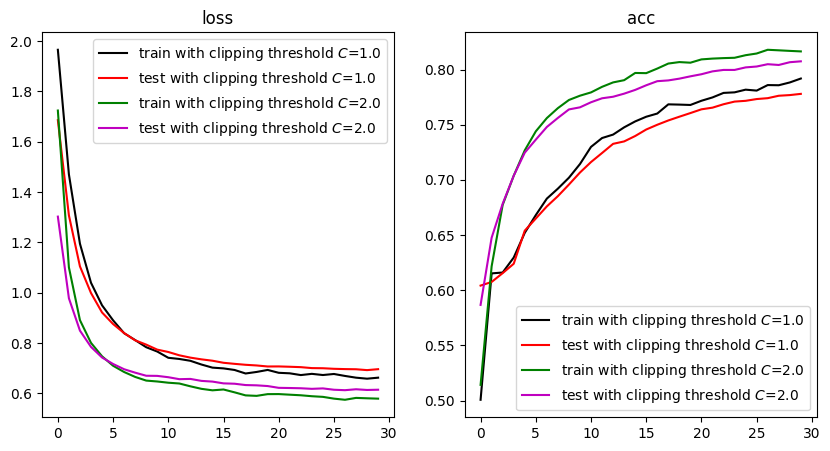

In [ ]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = mlp_clipping_1[i]
    p_history = mlp_clipping_2[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[6])
    ax.plot(epochs, np_history[1], color=color_list[2])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['train with clipping threshold $C$=1.0', 'test with clipping threshold $C$=1.0', 'train with clipping threshold $C$=2.0', 'test with clipping threshold $C$=2.0'])
    
plt.show()